### Imports

In [77]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import PPO, A2C, DQN 
from stable_baselines3.common.callbacks import BaseCallback

import torch

In [78]:
import os
os.chdir('/home/ishta/Analyzing-and-predicting-the-volatile-market-patterns-for-trading/Notebooks_RL_trading')

In [79]:
data = pd.read_csv('Datasets/eurusd_hour.csv')
data.rename(columns={'BC': 'Close'}, inplace=True)
data

,Date,Time,BO,BH,BL,Close,BCh,AO,AH,AL,AC,ACh
0,2005-05-02,00:00,1.28520,1.28520,1.28400,1.28440,-0.00080,1.28540,1.28540,1.28420,1.28460,-0.00080
1,2005-05-02,01:00,1.28440,1.28480,1.28390,1.28420,-0.00020,1.28460,1.28500,1.28410,1.28440,-0.00020
2,2005-05-02,02:00,1.28430,1.28540,1.28410,1.28510,0.00080,1.28450,1.28560,1.28430,1.28530,0.00080
3,2005-05-02,03:00,1.28510,1.28590,1.28500,1.28510,0.00000,1.28530,1.28610,1.28520,1.28530,0.00000
4,2005-05-02,04:00,1.28520,1.28590,1.28490,1.28550,0.00030,1.28540,1.28610,1.28510,1.28570,0.00030
...,...,...,...,...,...,...,...,...,...,...,...,...
93079,2020-04-29,18:00,1.08620,1.08851,1.08611,1.08713,0.00093,1.08660,1.08865,1.08640,1.08726,0.00066
93080,2020-04-29,19:00,1.08711,1.08823,1.08659,1.08748,0.00037,1.08725,1.08837,1.08675,1.08760,0.00035
93081,2020-04-29,20:00,1.08747,1.08788,1.08691,1.08708,-0.00039,1.08758,1.08810,1.08706,1.08808,0.00050
93082,2020-04-29,21:00,1.08708,1.08740,1.08699,1.08714,0.00006,1.08808,1.08814,1.08763,1.08766,-0.00042


### Create Env

In [80]:
env = gym.make('forex-v0', df=data, frame_bound=(100,10000), window_size=100)
env.observation_space

Box(-10000000000.0, 10000000000.0, (100, 2), float32)

### Define Functions

In [81]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

### Train + Test Env

In [82]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [PPO, A2C, DQN ]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : forex-v0
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 238.686: 100%|████████| 50/50 [00:04<00:00, 10.67it/s]


Min. Reward          :    238.686
Avg. Reward          :    238.686
Max. Reward          :    238.686
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:26, 995.55it/s]                                      
Episode: 40, Avg. Reward: -218.293: 100%|███████| 50/50 [03:20<00:00,  4.01s/it]


Min. Reward          :  -3439.018
Avg. Reward          :   -276.807
Max. Reward          :   2847.697
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 248.068: 100%|████████| 50/50 [03:18<00:00,  3.96s/it]


Min. Reward          :   -532.090
Avg. Reward          :    237.192
Max. Reward          :   1149.977
--------------------------------------------------------------------------------
model <class 'stable_baselines3.dqn.dqn.DQN'>
policy <class 'stable_baselines3.dqn.policies.DQNPolicy'>


Episode: 40, Avg. Reward: -236.493: 100%|███████| 50/50 [01:46<00:00,  2.12s/it]

Min. Reward          :  -1097.799
Avg. Reward          :   -255.020
Max. Reward          :    582.577


### Plot Results

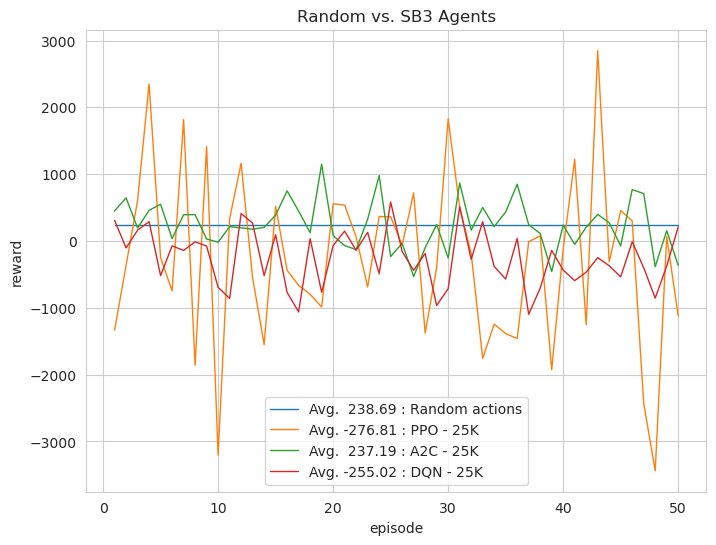

In [83]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()